<a href="https://colab.research.google.com/github/Farshad72/Twitter_Sentiment_Analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Fine Tuning Bert-base-uncased for Sentiment Analysis**
This is an example of fine-tuning Bert-base-uncased for sentiment classification using Twitter data. The first step is to import the required packages. Please ensure that you have installed them beforehand.

In [1]:
!pip install -q transformers
!pip install -q datasets
import os
import torch
import random
import pandas as pd
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.2 MB/s eta 0:00:00


## **Importing the Dataset**
We use load_dataset function to import data from the huggingface. Since the origina "tweet_eval" dataset is large (45k rows), we only download 25% of the dataset.

In [2]:
sentiment_dataset = load_dataset("tweet_eval", "sentiment", split="train[:25%]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## **Splitting the Data**
The process of splitting the data into train, test and validation set is as follows. First, we devide the whole data set into 60% of training set and 40% of primary test set. Then, the split the primary test set into 50% of test set and 50% validation set. Hence, the outcome is 60% of training set and 20% of test and validation sets respectively.

In [3]:
seed=42
new_dataset= sentiment_dataset.train_test_split(test_size=0.4, seed=seed)
new_dataset_2 = new_dataset['test'].train_test_split(test_size=0.5, seed=seed)
train_set = new_dataset['train']
test_set = new_dataset_2['test']
val_set = new_dataset_2['train']

## **Explanatory Data Analysis**

Each row of dataset consist of a text and label. The mapping of the lables to sentiments is as follows:

|Label|Sentiment|Text|
|:---|:---|:---|
| 0 | Negative | Thanks manager for putting me on the schedule for Sunday" |
| 1 | Neutral | Who's going to get them Gucci foams tomorrow|
| 2 | Positive| I'm sat at work just laughing at all these Hulk Hogan tweets. Hahha ffs|

The figure below illustrates the distribution of tweets across the training, test, and validation sets. While the percentage of each class remains consistent across the train, val, and test sets, the distribution of tweet sentiments is not uniform. For now, we train the model with this dataset. In the next part, we check how balancing the dataset affect the models performance.




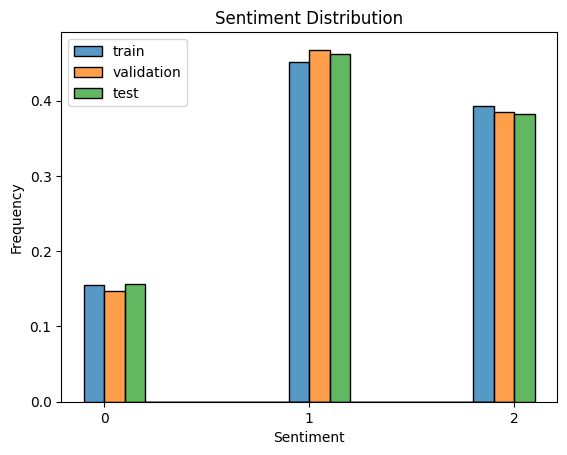

In [48]:
categories=['0','1','2']
x=sns.histplot(train_set.to_pandas()['label']-0.1,stat='proportion', binwidth=0.1)
y=sns.histplot(val_set.to_pandas()['label'],stat='proportion', binwidth=0.1)
z=sns.histplot(test_set.to_pandas()['label']+0.1,stat='proportion', binwidth=0.1)

plt.legend(['train', 'validation', 'test'])
plt.xticks(range(len(categories)), categories)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

## **TextClassificationDataset Class**
This class inherit from pytorch Dataset class ([details](https://pytorch.org/docs/stable/data.html)) and it is suitable for text classification task. Overall, the TextClassificationDataset class encode the input data with its label and pass it for training with its attention mask. We set the output tensor in pytorch format bacause we will use pytorch for training. We set the paddind and truncation true to prevent introducing erorr to training due to long or short texts.

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

## **BertClassification Class**
This class inherit form the torch.Module class ([details](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)) and specify the neural network model in pytorch environment. This class add a linear clasification layer to the bert model. We set the dropout probability to 0.2, meaning the neurons are ignored during training independently with probaility of 20%. The self.fc function Initializes a fully connected layer responsible for mapping the BERT model's output to the desired number of classes. The class output is the logits of each class, which is unnormalized propabbility and need to be transformed later to reflect the probability of each class for any input data.

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

## **Training Phase**

In this porject, we define a function for model traiing. Alternatively, you can use huggignface trainer function ([details](https://huggingface.co/docs/transformers/en/main_classes/trainer)). The model.train() argument set the model in the training mode. The optimizer.zero_grad clear gradients from previous iterations to avoid accumulating gradients through multiple backpropagation steps. The reaming  steps calcualte the loss and pass it to the training phase and update the model's parameters based on the calculated gradients, adjusting weights to reduce loss in subsequent iterations.

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

## **The Evaluation Function**
This function is designed to evaluate the performance of a text classification model on a given dataset. We will use this function both in the training part and for predicting the test set sentiment.


In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.to(device).tolist())
            actual_labels.extend(labels.to(device).tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

## **The Prediction Function**

This function is designed to predict the sentiment of any text. The difference between this function and the evaluate function lies in their input and output.

|function|input|output|
|:---|:---|:---|
| evaluate | Pytorch DataLoader class | accuracy_score and classification_report |
| predict_sentiment | text (string) | input sentiment|

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return preds.item()

## **Model and Hyperparameters**
we set the model as bert-base-uncased and define the hyperparameter. These parameters should be iterated to find the optimum outcome. We will run the model with different sets of parameters in the finetuning step.

In [ ]:
bert_model_name = 'bert-base-uncased'
num_classes = 3
max_length = 128
batch_size = 32
num_epochs = 3
learning_rate = 1e-5

## **Setting up the Tokenizer and Preparing the Data**

We set the tokenizer as BertTokenier, suitbale for tokenizing text for bert models. The training and validation data is encoded with the TextClassification class which defined earlier. Finally, the data should be converted for batch processing using DataLoader function.

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_set['text'], train_set['label'], tokenizer, max_length)
val_dataset = TextClassificationDataset(val_set['text'], val_set['label'], tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## **Setting the Device**
Finetuning the LLMS require heavy computation. Hence, the priority is to use GPU or TPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)
print(device)

## **Optimizer, Steps and Scheduler**

- creates an optimizer object using the AdamW algorithm (```torch.optim.AdamW```). AdamW is a popular optimizer choice in deep learning, known for its efficiency and effectiveness.

- This line calculates the total number of training steps the model will go through.
len(train_dataloader): This provides the number of batches in your training data loader.
num_epochs: This represents the number of times you plan to iterate through the entire training dataset.
Multiplying these two values gives you the total number of steps (iterations) your training loop will execute. This information is crucial for the learning rate scheduler we'll create next.

- This line creates a learning rate scheduler object using the get_linear_schedule_with_warmup function (likely from a library like transformers from
```Huggingface```
).
A learning rate scheduler is a technique for adjusting the learning rate during training. Here, we're using a linear scheduler with warmup.





In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

## **Early stopping**

To mitigate the risk of overfitting, where training loss continues to decline while validation loss begins to rise, we introduce the EarlyStopping class. This class monitors the validation loss after each training epoch, halting the training process if the loss no longer decreases. To ensure that the model doesn't prematurely stop training, we also set a patience threshold, allowing the validation loss to continue decreasing for a specified number of epochs before terminating the training.

In [ ]:
class early_stopping:
  def __init__(self, patience=3, min_delta=0.01):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
  def __call__(self, val_loss):
    if self.counter >= self.patience:
      return True
    elif val_loss < self.best_val_loss - self.min_delta:
      self.best_val_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
    return False



## **Iterates Through Training Epoch**
This code iterates through training epochs, performs training and evaluation within each epoch, and provides informative feedback on training progress through loss values and detailed evaluation metrics on the validation data.

In [ ]:
early_stopping_callback = early_stopping()
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        val_loss = 0.0
        train_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
              input_ids = batch['input_ids'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              labels = batch['label'].to(device)
              outputs = model(input_ids=input_ids, attention_mask=attention_mask)
              loss = nn.CrossEntropyLoss()(outputs, labels)
              val_loss += loss.item()
            for batch in train_dataloader:
              input_ids = batch['input_ids'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              labels = batch['label'].to(device)
              outputs = model(input_ids=input_ids, attention_mask=attention_mask)
              loss = nn.CrossEntropyLoss()(outputs, labels)
              train_loss += loss.item()
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        if early_stopping_callback(val_loss):
          print(f"Early stopping at epoch:{epoch+1}")
          break
        print(f"Training Loss: {train_loss:.4f}")  # Print validation loss
        print(f"Validation Loss: {val_loss:.4f}")  # Print validation loss
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

## **Model Performance on Test set**

Finally, we check the model performance on the unseen test set. The test set should first preprocessed (encode, batching, truncation, etc.) using DataLoader library. The evaluation function provide the detaield performacne metrics for the entire test set.

In [ ]:
test_dataset = TextClassificationDataset(test_set['text'], test_set['label'], tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
evaluate(model, test_dataloader, device)


## **Hyperparameter Optimization**

We test the model on different sets of hyperparameter to choose the best model. The list of the hyperparameters are as follows:

|parameter|description|
|:---|:---|
| learning rate | Adjusts step size in gradient descent optimization algorithm |
| batch size |Number of samples processed before updating model parameters |
| dropout | Randomly deactivates neurons during training to prevent overfitting |
| weight decay |  Regularization technique to penalize large weight values |
| warm up steaps ratio | Ratio of total stapes that learning rate gradually increases initially to reach its value |
| max length | Maximum length of input sequence for model processing |

Below is the numerical quantity for each finetuning effort:

|Model number|learning rate|batch size|dropout|weight decay|warm up steps|max length|
|:---|:---|:---|:---|:---|:---|:---|
|1|5e-5|32|0.5|0|0|128|
|2|1e-5|32|0.5|0|0|128|
|3|5e-6|32|0.5|0|0|128|
|4|5e-6|32|0.5|0|0.1|128|
|5|5e-6|64|0.2|0|0|128|
|6|5e-6|32|0.4|0|0|128|
|7|5e-6|32|0.4|0.1|0|128|
|8|5e-6|32|0.2|0.2|0|128|
|9|5e-6|32|0.4|0.3|0|128|
|10|5e-6|64|0.4|0.2|0|128|
|11|5e-6|64|0.4|0.2|0.1|128|
|12|5e-6|32|0.4|0.2|0|256|
   
  


<div style="text-align:center;">

 <img src="https://drive.google.com/uc?id=1Y7MrhJEOQEUFQfr7aJQ6Mxxqvjm1sDMy" width=600>

 <img src="https://drive.google.com/uc?id=1sZ-PS_1m-7JY3tI0zhEpAwAp_KM76YBZ" width=600>

 <img src="https://drive.google.com/uc?id=13OaxW9WVoAowiKl3pv43GYiDi3GMxcu2" width=600>

</div>







The criteria for comparing the models is validation accuracy which achieved by model-2 with 0.72 accuracy after three epochs of trainng. The model shows 69% accuracy on the test data.

## **Conclusion**

While hyperparameter finetuning helped us to find the model with maximum validation accuracy, the difference in validation loss and validation accuracy among these models are not significantly. One of the reason for the similarity of outcome is that during trainng, we freezed major part of the model and only train the last layer of the model (classification head). The .There are furthersteps that we can do to improve the models's outcome:

1- Refine the input data and have more balance dataset for each sentiment class

2- Check other LLM's model and compare its result to Bert based model that we use in this project

3- Here we are fine-tuning the Bert-Model and rely on its underlying knowledge. While this method help us use the valuable insight a LLM gained during its training, it limit the model to adjust to our dataset.

Continue!